# First Year Paper Code

### Alternative ML models with RF as stage 1 predictor

In [1]:
import cvxpy as cp
import numpy as np
import warnings
import sys
from IPython.core.interactiveshell import InteractiveShell
import torch
import torch.optim as optim
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt


from sklearn.ensemble import RandomForestRegressor


import time
from tqdm import tqdm

np.random.seed(42)
torch.manual_seed(42)

warnings.filterwarnings("ignore")
InteractiveShell.ast_node_interactivity = "all"
sys.path.insert(1,'E:\\User\\Stevens\\Spring 2024\\PTO - Fairness\\myGit\\myUtils')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
class SimpleNeuralNetwork(nn.Module):
    def __init__(self, num_items, num_features):
        super(SimpleNeuralNetwork, self).__init__()
        self.num_items = num_items
        self.num_features = num_features
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(num_features, 64),
                nn.ReLU(),
                nn.Linear(64, 1)
            ) for _ in range(num_items)
        ])

    def forward(self, x):
        outputs = []
        for i in range(self.num_items):
            outputs.append(torch.sigmoid(self.layers[i](x[:, i, :])))
        return torch.cat(outputs, dim=1)

In [3]:
class RandomForestModel:
    def __init__(self, num_items, num_features, n_estimators=100, max_depth=None):
        self.num_items = num_items
        self.num_features = num_features
        self.models = [RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth) for _ in range(num_items)]
        
    def fit(self, X, y):
        """
        X: numpy array of shape (num_samples, num_items, num_features)
        y: numpy array of shape (num_samples, num_items) - targets for each item
        """
        for i in range(self.num_items):
            X_item = X[:, i, :]  # Extract features for item i
            y_item = y[:, i]     # Extract targets for item i
            self.models[i].fit(X_item, y_item)
    
    def predict(self, X):
        """
        X: numpy array of shape (num_samples, num_items, num_features)
        Returns:
        predictions: numpy array of shape (num_samples, num_items) - predicted values for each item
        """
        predictions = []
        for i in range(self.num_items):
            X_item = X[:, i, :]  # Extract features for item i
            predictions.append(self.models[i].predict(X_item))
        return np.column_stack(predictions)


In [4]:
def genData(num_data, num_features, num_items, seed=42, Q=100, dim=1, deg=1, noise_width=0.5, epsilon=0.1):
    rnd = np.random.RandomState(seed)
    n = num_data
    p = num_features
    m = num_items
    
    # Split the population into group A (1/4) and group B (3/4)
    group_A_size = n // 4
    group_B_size = n - group_A_size
    
    # Generate x with a bias for group A
    x = np.zeros((n, m, p))
    x[:group_A_size] = rnd.normal(0.5, 1, (group_A_size, m, p))  # Slightly higher mean for group A
    x[group_A_size:] = rnd.normal(0, 1, (group_B_size, m, p))   # Standard distribution for group B
    
    B = rnd.binomial(1, 0.5, (m, p))

    c = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            values = (np.dot(B[j], x[i, j].reshape(p, 1)).T / np.sqrt(p) + 3) ** deg + 1
            values *= 5
            values /= 3.5 ** deg
            epislon = rnd.uniform(1 - noise_width, 1 + noise_width, 1)
            values *= epislon
            
            # Introduce bias for c: Group A has slightly higher values, Group B slightly lower
            if i < group_A_size:
                values *= 1.1  # Increase c for Group A
            else:
                values *= 0.9  # Decrease c for Group B
            
            values = np.ceil(values)
            c[i, j] = values

    c = c.astype(np.float64)
    r = np.zeros((n, m))
    for i in range(n):
        for j in range(m):
            # Generate r using normal distribution, then clip to [0, 1] range
            r[i, j] = np.clip(rnd.normal(0.5, 0.2), 0, 1)
            
            # Introduce bias for r: Group A has slightly lower values, Group B slightly higher
            if i < group_A_size:
                r[i, j] -= 0.1  # Decrease r for Group A
            else:
                r[i, j] += 0.1  # Increase r for Group B
            
            # Clip again to ensure values remain in [0, 1] range
            r[i, j] = np.clip(r[i, j], 0, 1)

    return x, r, c, Q

In [5]:
class optModelClosed:
    """
    This is a class for optimization models.
    """

    def __init__(self, r, c, Q, alpha=0.5):
        self.r = r
        self.c = c
        self.Q = Q
        self.alpha = alpha
        self.num_data = num_data
        self.num_items = num_items
        
    def __repr__(self):
        return 'optModel ' + self.__class__.__name__
    
    def setObj2(self, a, r, b, c, Q, epsilon=0.01, alpha=0.5):
        if alpha == 1:
            self.objective = cp.sum(cp.log(a * r + b * self.d + epsilon))
        else:
            self.objective = cp.sum(cp.power(a * r + b * self.d + epsilon, 1 - alpha)) / (1 - alpha)
        
        self.constraints = [
            cp.sum(cp.multiply(c, self.d)) <= Q
        ]
        
        self.problem = cp.Problem(cp.Maximize(self.objective), self.constraints)
        self.a = a
        self.r = r
        self.b = b
        self.c = c
        self.Q = Q
        self.epsilon = epsilon


    def setObj(self, r, c):

        if self.alpha == 1:
            self.objective = cp.sum(cp.log(cp.multiply(r, self.d)))
        else:
            self.objective = cp.sum(cp.power(cp.multiply(r, self.d), 1 - self.alpha)) / (1 - self.alpha)
        
        self.constraints = [
            self.d >= 0,
            cp.sum(cp.multiply(c, self.d)) <= self.Q
        ]
        self.problem = cp.Problem(cp.Maximize(self.objective), self.constraints)

    
    def solveS(self, closed=False):
        """
        A method to solve the optimization problem for one set of parameters.

        Args:
            r (np.ndarray): The r parameter for the optimization
            c (np.ndarray): The c parameter for the optimization
            closed (bool): solving the problem in closed form

        Returns:
            tuple: optimal solution and optimal value
        """
        if closed:
            return self.solveC()

        self.d = cp.Variable(self.num_items)
        self.setObj(self.r, self.c)
        self.problem.solve(abstol=1e-9, reltol=1e-9, feastol=1e-9)
        opt_sol = self.d.value
        opt_val = self.problem.value

        return opt_sol, opt_val


    def solve(self):
        """
        A method to solve the optimization problem in closed form for one set of parameters.

        Args:
            r (np.ndarray): The r parameter for the optimization
            c (np.ndarray): The c parameter for the optimization

        Returns:
            tuple: optimal solution and optimal value
        """
        r = self.r
        c = self.c
        if self.alpha == 1:
            raise ValueError("Work in progress")
        c = c.cpu().numpy() if isinstance(c, torch.Tensor) else c
        r = r.cpu().numpy() if isinstance(r, torch.Tensor) else r
        S = np.sum(c ** (1 - 1 / self.alpha) * r ** (-1 + 1 / self.alpha))
        opt_sol_c = (c ** (-1 / self.alpha) * r ** (-1 + 1 / self.alpha) * self.Q) / S
        opt_val_c = np.sum((r * opt_sol_c) ** (1 - self.alpha)) / (1 - self.alpha)

        return opt_sol_c, opt_val_c
    
    def solveC2(self):
        """
        A method to solve the optimization problem in closed form using the given formula.

        Returns:
            tuple: optimal solution and optimal value
        """
        if self.alpha == 1:
            raise ValueError("Work in progress")

        a = self.a
        r = self.r
        b = self.b
        c = self.c
        epsilon = self.epsilon
        Q = self.Q
        alpha = self.alpha

        b_inverse_alpha = b ** (-1 / alpha)
        c_over_b = c / b
        ar_plus_epsilon = a * r + epsilon

        S1 = np.sum(c_over_b * ar_plus_epsilon)
        S2 = np.sum(c_over_b ** (1 - 1 / alpha))

        d_star = b_inverse_alpha * (Q + S1) / S2 - ar_plus_epsilon * b_inverse_alpha / b

        opt_val_c2 = np.sum((a * r + b * d_star + epsilon) ** (1 - alpha)) / (1 - alpha)

        return d_star, opt_val_c2

In [6]:
class optModel:
    """
    This is a class for optimization models.
    """

    def __init__(self, r, c, Q, alpha=0.5):
        self.r = r
        self.c = c
        self.Q = Q
        self.alpha = alpha
        self.num_data = num_data
        self.num_items = num_items

    def __repr__(self):
        return 'optModel ' + self.__class__.__name__
    
    def setObj2(self, a, r, b, c, Q, epsilon=0.01, alpha=0.5):
        if alpha == 1:
            self.objective = cp.sum(cp.log(a * r + b * self.d + epsilon))
        else:
            self.objective = cp.sum(cp.power(a * r + b * self.d + epsilon, 1 - alpha)) / (1 - alpha)
        
        self.constraints = [
            cp.sum(cp.multiply(c, self.d)) <= Q
        ]
        
        self.problem = cp.Problem(cp.Maximize(self.objective), self.constraints)
        self.a = a
        self.r = r
        self.b = b
        self.c = c
        self.Q = Q
        self.epsilon = epsilon


    def get_dual_values(self):
        """
        Returns the dual variables (dual_lambda and mu).
        """
        return self.dual_lambda, self.mu

    def setObj(self, r, c):

        if self.alpha == 1:
            self.objective = cp.sum(cp.log(cp.multiply(r, self.d)))
        else:
            self.objective = cp.sum(cp.power(cp.multiply(r, self.d), 1 - self.alpha)) / (1 - self.alpha)
        
        self.constraints = [
            self.d >= 0,
            cp.sum(cp.multiply(c, self.d)) <= self.Q
        ]
        self.problem = cp.Problem(cp.Maximize(self.objective), self.constraints)

    
    def solve(self, closed=False):
        """
        A method to solve the optimization problem for one set of parameters.

        Args:
            r (np.ndarray): The r parameter for the optimization
            c (np.ndarray): The c parameter for the optimization
            closed (bool): solving the problem in closed form

        Returns:
            tuple: optimal solution and optimal value
        """
        if closed:
            return self.solveC()

        self.d = cp.Variable(self.num_items)
        self.setObj(self.r, self.c)
        self.problem.solve(abstol=1e-9, reltol=1e-9, feastol=1e-9)
        opt_sol = self.d.value
        opt_val = self.problem.value

        return opt_sol, opt_val


    def solveC(self):
        """
        A method to solve the optimization problem in closed form for one set of parameters.

        Args:
            r (np.ndarray): The r parameter for the optimization
            c (np.ndarray): The c parameter for the optimization

        Returns:
            tuple: optimal solution and optimal value
        """
        r = self.r
        c = self.c
        if self.alpha == 1:
            raise ValueError("Work in progress")
        c = c.cpu().numpy() if isinstance(c, torch.Tensor) else c
        r = r.cpu().numpy() if isinstance(r, torch.Tensor) else r
        S = np.sum(c ** (1 - 1 / self.alpha) * r ** (-1 + 1 / self.alpha))
        opt_sol_c = (c ** (-1 / self.alpha) * r ** (-1 + 1 / self.alpha) * self.Q) / S
        opt_val_c = np.sum((r * opt_sol_c) ** (1 - self.alpha)) / (1 - self.alpha)

        return opt_sol_c, opt_val_c
    
    def solveC2(self):
        """
        A method to solve the optimization problem in closed form using the given formula.

        Returns:
            tuple: optimal solution and optimal value
        """
        if self.alpha == 1:
            raise ValueError("Work in progress")

        a = self.a
        r = self.r
        b = self.b
        c = self.c
        epsilon = self.epsilon
        Q = self.Q
        alpha = self.alpha

        b_inverse_alpha = b ** (-1 / alpha)
        c_over_b = c / b
        ar_plus_epsilon = a * r + epsilon

        S1 = np.sum(c_over_b * ar_plus_epsilon)
        S2 = np.sum(c_over_b ** (1 - 1 / alpha))

        d_star = b_inverse_alpha * (Q + S1) / S2 - ar_plus_epsilon * b_inverse_alpha / b

        opt_val_c2 = np.sum((a * r + b * d_star + epsilon) ** (1 - alpha)) / (1 - alpha)

        return d_star, opt_val_c2

In [7]:
class optDataset(Dataset):
    """
    This class is Torch Dataset class for optimization problems.
    """

    def __init__(self, features, costs, r, Q, alpha=0.5, closed=False):
        """
        A method to create a optDataset from optModel

        Args:
            model (optModel): optimization model
            features (np.ndarray): features
            c (np.ndarray): c of objective function
            r (np.ndarray): r of objective function
            Q (float): budget
            alpha (float): alpha of objective function
            closed (bool): solving the problem in closed form

        """
        self.feats = features
        self.costs = costs
        self.r = r
        self.Q = Q
        self.alpha = alpha
        self.closed = closed

        self.sols, self.objs = self._getSols()

    def _getSols(self):
        """
        A method to get the solutions of the optimization problem
        """
        opt_sols = []
        opt_objs = []
        
        for i in tqdm(range(len(self.costs))):
            sol, obj = self._solve(self.r[i], self.costs[i])
            opt_sols.append(sol)
            opt_objs.append([obj])
        
        return np.array(opt_sols), np.array(opt_objs)

    def  _solve(self, r, c):
        """
        A method to solve the optimization problem to get oan optimal solution with given r and c

        Args:
            r (np.ndarray): r of objective function
            c (np.ndarray): c of objective function

        Returns:
            tuple: optimal solution (np.ndarray), objective value (float)
        """
        self.model = optModelClosed(r, c, self.Q, self.alpha)
        if self.closed:
            return self.model.solveC()
        else:
            return self.model.solve()

    def __len__(self):
        """
        A method to get data size

        Returns:
            int: the number of optimization problems
        """
        return len(self.costs)
    
    def __getitem__(self, index):
        """
        A method to retrieve data

        Args:
            index (int): data index

        Returns:
            tuple: data features (torch.tensor), costs (torch.tensor), optimal solutions (torch.tensor) and objective values (torch.tensor)
        """
        return (
            torch.FloatTensor(self.feats[index]), # x 
            torch.FloatTensor(self.costs[index]), # c
            torch.FloatTensor(self.r[index]), # r 
            torch.FloatTensor(self.sols[index]),# optimal solution
            torch.FloatTensor(self.objs[index]), # objective value
        )

In [8]:
# class LinearRegressionModel(nn.Module):
#     def __init__(self, num_items, num_features):
#         super(LinearRegressionModel, self).__init__()
#         self.num_items = num_items
#         self.num_features = num_features
#         self.linears = nn.ModuleList([nn.Linear(num_features, 1) for _ in range(num_items)])

#     def forward(self, x):
#         outputs = []
#         for i in range(self.num_items):
#             outputs.append(torch.sigmoid(self.linears[i](x[:, i, :])))
#         return torch.cat(outputs, dim=1)

In [9]:
def objValue(d, r, alpha=0.5):
    """
    A function to calculate objective value
    """
    if alpha == 1:
        return np.sum(np.log(np.multiply(r, d)))
    else:
        return np.sum(np.power(np.multiply(r, d), 1 - alpha)) / (1 - alpha)

def regret(rf_model, optmodel, dataloader):
    """
    A function to evaluate model performance with normalized true regret

    Args:
        rf_model (RandomForestModel): a RandomForest model for cost prediction
        optmodel (optModel): an optimization model (e.g., PyEPO)
        dataloader (DataLoader): Torch dataloader from optDataSet

    Returns:
        float: true regret loss
    """
    loss = 0
    optsum = 0
    
    for data in dataloader:
        x, c, r, d, z = data
        if torch.cuda.is_available():
            x, c, r, d, z = x.cpu().numpy(), c.cpu().numpy(), r.cpu().numpy(), d.cpu().numpy(), z.cpu().numpy()

        # Predict with the RandomForest model
        rp = rf_model.predict(x)

        # Solve and accumulate regret for each sample in the batch
        for j in range(rp.shape[0]):
            loss += calRegret(optmodel, c[j], rp[j], r[j], z[j])
        
        optsum += abs(z).sum()

    # Normalization
    return loss / (optsum + 1e-7)


def calRegret(optmodel, cost, pred_r, true_r, true_obj):
    """
    A function to calculate normalized true regret for a batch

    Args:
        optmodel (optModel): optimization model
        pred_cost (torch.tensor): predicted costs
        true_cost (torch.tensor): true costs
        true_obj (torch.tensor): true optimal objective values

    Returns:predmodel
        float: true regret losses
    """
    # opt sol for pred cost
    model = optmodel(pred_r, cost, Q, alpha=0.5)
    sol, _ = model.solve()
    # obj with true cost
    obj = objValue(sol, true_r, alpha=0.5)
    # loss
    loss = true_obj - obj
    return loss

In [10]:
def visLearningCurve(loss_log, loss_log_regret, mse_loss_log):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

    # Plot original loss log
    ax1.plot(loss_log, color="c", lw=2)
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iters", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title("Learning Curve (Training Loss)", fontsize=16)

    # Plot regret log
    ax2.plot(loss_log_regret, color="royalblue", ls="--", alpha=0.7, lw=2)
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret", fontsize=16)
    ax2.set_title("Learning Curve (Test Regret)", fontsize=16)

    # Plot new MSE loss log
    ax3.plot(mse_loss_log, color="orange", lw=2)
    ax3.tick_params(axis="both", which="major", labelsize=12)
    ax3.set_xlabel("Iters", fontsize=16)
    ax3.set_ylabel("MSE Loss", fontsize=16)
    ax3.set_title("Learning Curve (MSE Loss)", fontsize=16)

    plt.tight_layout()
    plt.show()

### Generate Data

In [11]:
num_data = 2000
num_features = 20
num_items = 5
x, r, c, Q = genData(num_data, num_features, num_items)
# create optmodel instance
optmodel = optModel(r, c, Q, alpha=0.5)

In [12]:
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
x_train, x_test, c_train, c_test, r_train, r_test = train_test_split(x, c, r, test_size=0.2, random_state=42)

In [13]:
# Create datasets and dataloaders
dataset_train = optDataset(x_train, c_train, r_train, Q, alpha=0.5, closed=False)
dataset_test = optDataset(x_test, c_test, r_test, Q, alpha=0.5, closed=False)
batch_size = 32
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

100%|██████████| 1600/1600 [00:00<00:00, 94433.07it/s]


100%|██████████| 400/400 [00:00<00:00, 57330.56it/s]


In [14]:
# view one slice of data
r[0]

array([0.42782192, 0.39185518, 0.25602175, 0.85686333, 0.22423475])

## The Pertubed Gradient Regret Loss

In [15]:
# Define Pertubed Regret Loss
from torch.autograd import Function

class RegretLossFunction(Function):
    @staticmethod
    def forward(ctx, optmodel, cost, pred_r, true_r, true_obj, Q, alpha):
        batch_size = pred_r.size(0)
        losses = torch.zeros(batch_size, device=pred_r.device)
        
        pred_r_np = pred_r.detach().cpu().numpy()
        true_r_np = true_r.detach().cpu().numpy()
        cost_np = cost.detach().cpu().numpy()
        
        for i in range(batch_size):
            # opt sol for pred cost
            model = optmodel(pred_r_np[i], cost_np[i], Q, alpha=alpha)
            sol, _ = model.solve()
            # obj with true cost
            obj = objValue(sol, true_r_np[i], alpha=alpha)

            losses[i] = true_obj[i] - obj
        
        # Store necessary tensors for backward pass
        ctx.save_for_backward(pred_r, true_r, cost, true_obj)
        ctx.optmodel = optmodel
        ctx.Q = Q
        ctx.alpha = alpha
        ctx.losses = losses

        return losses.mean().to(pred_r.device)

    @staticmethod
    def backward(ctx, grad_output):

        pred_r, true_r, cost, true_obj = ctx.saved_tensors
        optmodel = ctx.optmodel
        Q = ctx.Q
        alpha = ctx.alpha

        batch_size = pred_r.size(0)
        grad_pred_r = torch.zeros_like(pred_r)
        
        epsilon = 1e-5

        for i in range(batch_size):
            pred_r_np = pred_r[i].detach().cpu().numpy()
            cost_np = cost[i].detach().cpu().numpy()
            true_r_np = true_r[i].detach().cpu().numpy()
            
            gradient = np.zeros_like(pred_r_np)
            for j in range(pred_r_np.size):
                perturbed_pred_r = np.copy(pred_r_np)
                perturbed_pred_r[j] += epsilon
                
                # Compute loss with perturbed pred_r
                model = optmodel(perturbed_pred_r, cost_np, Q, alpha=alpha)
                sol, _ = model.solve()
                obj = objValue(sol, true_r_np, alpha=alpha)
                loss_perturbed = true_obj[i] - obj
                
                # Finite difference approximation
                gradient[j] = (loss_perturbed - ctx.losses[i].item()) / epsilon
            
            grad_pred_r[i] = torch.tensor(gradient, device=pred_r.device)
        
        grad_pred_r = grad_output.view(-1, 1) * grad_pred_r

        return None, None, grad_pred_r, None, None, None, None

class RegretLoss(nn.Module):
    def __init__(self, optmodel, Q, alpha=0.5):
        super(RegretLoss, self).__init__()
        self.optmodel = optmodel
        self.Q = Q
        self.alpha = alpha

    def forward(self, pred_r, true_r, cost, true_obj):
        return RegretLossFunction.apply(self.optmodel, cost, pred_r, true_r, true_obj, self.Q, self.alpha)


In [22]:
def trainModelRF(rf_model, loss_func, optmodel, loader_train, loader_test, num_epochs=10):
    mse_loss_func = nn.MSELoss()  # Fixed MSE loss metric
    
    # Initialize logs
    loss_log_train_regret = []  # Regret loss on training set
    mse_loss_log_train = []     # MSE loss on training set
    loss_log_test_regret = []   # Regret loss on test set
    mse_loss_log_test = []      # MSE loss on test set
    
    elapsed = 0

    for epoch in range(num_epochs):
        tick = time.time()

        # Training phase: fit the model on the entire training data
        for i, data in enumerate(loader_train):
            x_train, c_train, r_train, d_train, z_train = data
            if torch.cuda.is_available():
                x_train, c_train, r_train, d_train, z_train = (
                    x_train.cpu().numpy(), 
                    c_train.cpu().numpy(), 
                    r_train.cpu().numpy(), 
                    d_train.cpu().numpy(), 
                    z_train.cpu().numpy()
                )

            # Train the Random Forest on the training data
            rf_model.fit(x_train, r_train)

        tock = time.time()
        elapsed += tock - tick

        # --- Training set evaluation ---
        rp_train = rf_model.predict(x_train)  # Predictions for training data
        rp_train_tensor = torch.tensor(rp_train)  # Convert predictions to tensor
        r_train_tensor = torch.tensor(r_train)

        # Compute MSE loss (new fixed metric) for training
        train_mse_loss = mse_loss_func(rp_train_tensor, r_train_tensor)
        mse_loss_log_train.append(train_mse_loss.item())  # Log MSE for training

        # Compute the regret loss for training using the regret function
        train_regret_loss = regret(rf_model, optmodel, loader_train)
        loss_log_train_regret.append(train_regret_loss)  # Log regret for training

        # --- Test set evaluation ---
        for i, data_test in enumerate(loader_test):
            x_test, c_test, r_test, d_test, z_test = data_test
            if torch.cuda.is_available():
                x_test, c_test, r_test, d_test, z_test = (
                    x_test.cpu().numpy(), 
                    c_test.cpu().numpy(), 
                    r_test.cpu().numpy(), 
                    d_test.cpu().numpy(), 
                    z_test.cpu().numpy()
                )

            # Predictions for the test data
            rp_test = rf_model.predict(x_test)
            rp_test_tensor = torch.tensor(rp_test)  # Convert predictions to tensor
            r_test_tensor = torch.tensor(r_test)

            # Compute MSE loss for test set
            test_mse_loss = mse_loss_func(rp_test_tensor, r_test_tensor)
            mse_loss_log_test.append(test_mse_loss.item())  # Log MSE for test

            # Compute the regret loss for test using the regret function
            test_regret_loss = regret(rf_model, optmodel, loader_test)
            loss_log_test_regret.append(test_regret_loss)  # Log regret for test

        # Print progress after each epoch
        # Here, ensure that `train_regret_loss` and `test_regret_loss` are scalar values
        train_regret_scalar = float(train_regret_loss) if not isinstance(train_regret_loss, (list, np.ndarray)) else train_regret_loss[0]
        test_regret_scalar = float(test_regret_loss) if not isinstance(test_regret_loss, (list, np.ndarray)) else test_regret_loss[0]
        
        print(f"Epoch {epoch + 1:2}, Train Regret: {train_regret_scalar * 100:7.4f}%, Train MSE: {train_mse_loss.item():7.4f}, "
              f"Test Regret: {test_regret_scalar * 100:7.4f}%, Test MSE: {test_mse_loss.item():7.4f}")
    
    print(f"Total Elapsed Time: {elapsed:.2f} Sec.")

    return loss_log_train_regret, mse_loss_log_train, loss_log_test_regret, mse_loss_log_test


Epoch  1, Train Regret:  1.7920%, Train MSE:  0.0061, Test Regret:  1.8827%, Test MSE:  0.0383
Epoch  2, Train Regret:  1.8076%, Train MSE:  0.0073, Test Regret:  1.8700%, Test MSE:  0.0364
Epoch  3, Train Regret:  1.8186%, Train MSE:  0.0066, Test Regret:  1.8622%, Test MSE:  0.0379
Epoch  4, Train Regret:  1.8015%, Train MSE:  0.0068, Test Regret:  1.8849%, Test MSE:  0.0337
Epoch  5, Train Regret:  1.8708%, Train MSE:  0.0074, Test Regret:  1.9744%, Test MSE:  0.0422
Epoch  6, Train Regret:  1.7664%, Train MSE:  0.0067, Test Regret:  1.8948%, Test MSE:  0.0419
Epoch  7, Train Regret:  1.8289%, Train MSE:  0.0070, Test Regret:  1.8150%, Test MSE:  0.0365
Epoch  8, Train Regret:  1.9562%, Train MSE:  0.0076, Test Regret:  2.0139%, Test MSE:  0.0424
Epoch  9, Train Regret:  1.7805%, Train MSE:  0.0064, Test Regret:  1.7810%, Test MSE:  0.0354
Epoch 10, Train Regret:  1.7948%, Train MSE:  0.0080, Test Regret:  1.8192%, Test MSE:  0.0374
Total Elapsed Time: 235.37 Sec.


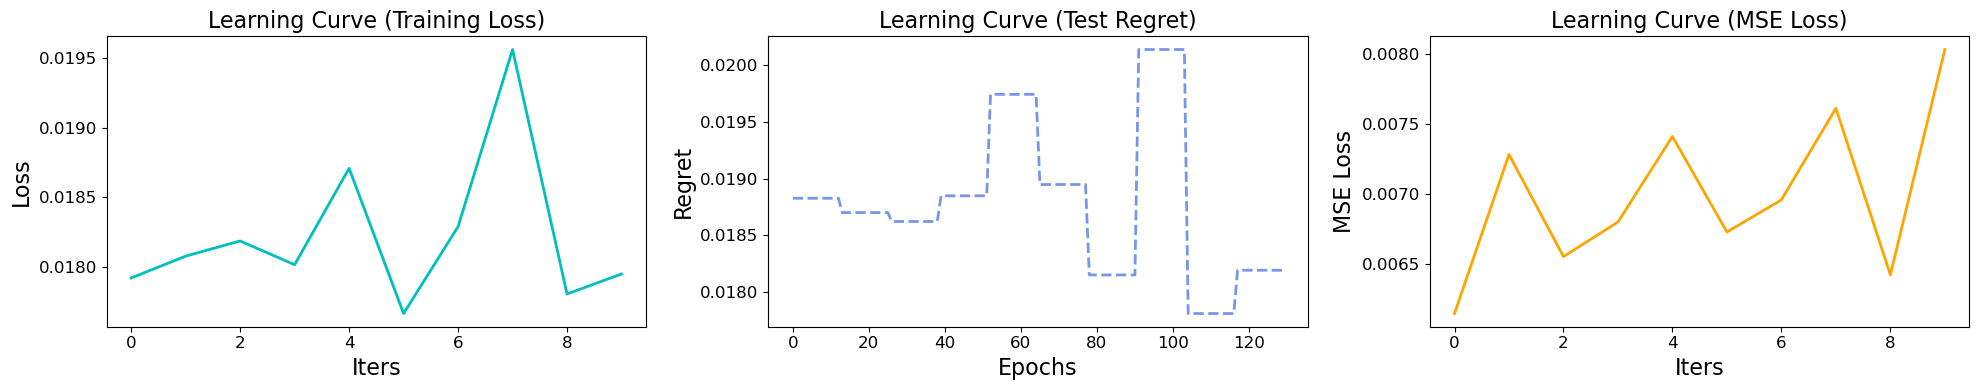

In [24]:
import torch.nn as nn

rf_model = RandomForestModel(num_items=num_items, num_features=num_features, n_estimators=100, max_depth=5)

# Use regret function to calculate regret loss
optmodel = optModel  # Assuming optModel is defined elsewhere

# Train the Random Forest model
loss_log_train_regret, mse_loss_log_train, loss_log_test_regret, mse_loss_log_test = trainModelRF(
    rf_model, nn.MSELoss, optmodel, loader_train, loader_test, num_epochs=10)

# Visualize the learning curves (assuming visLearningCurve handles multiple logs)
visLearningCurve(loss_log_train_regret, loss_log_test_regret, mse_loss_log_train)

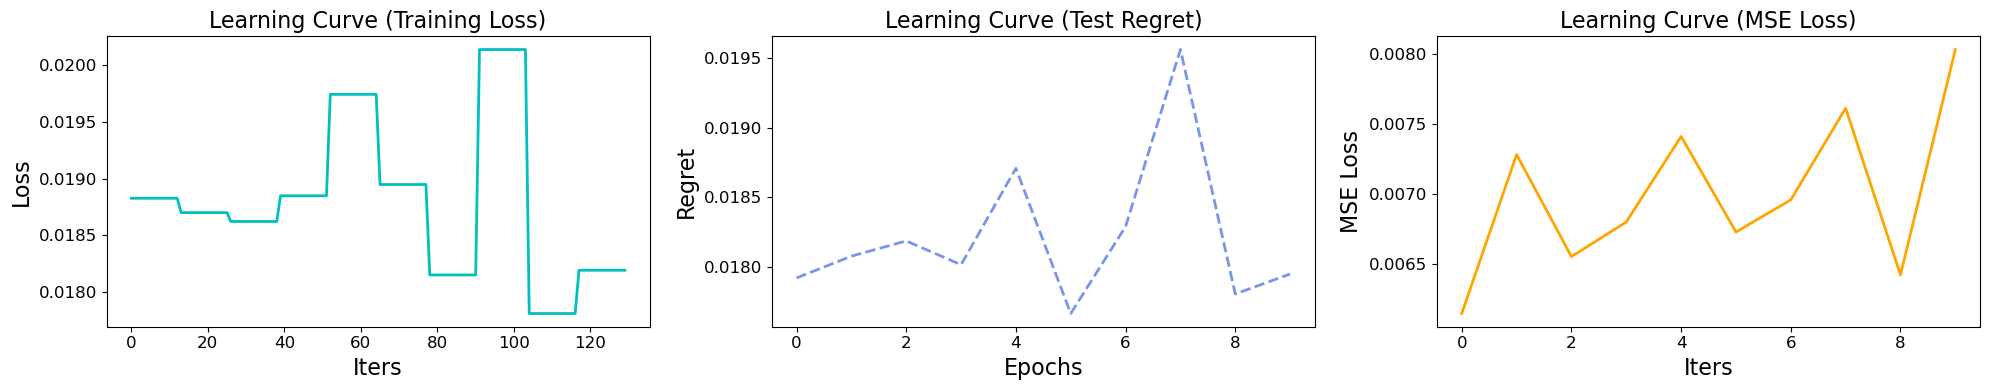

In [26]:
visLearningCurve(loss_log_test_regret, loss_log_train_regret, mse_loss_log_train)